# Дослідження датасету Fashion MNIST з допомогою згорткових нейронний мереж

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras as K
from sklearn.metrics import classification_report
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LayerNormalization
from keras import optimizers
from keras import losses
from keras import metrics
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import img_to_array, array_to_img
from keras.callbacks import ModelCheckpoint

## Завантажуємо датасет

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
random_seed = 42
tf.random.set_seed(random_seed)

## Підготуємо дані для VGG16. Для цього картинки треба збільшити. Хоча мінімально допустимий розмір 32х32 ми поекспериментуємо з розмірами 48х48 та 100х100

In [3]:
#vgg_image_size = 32
vgg_image_size = 100

vgg_train_images = np.dstack([train_images] * 3).reshape((60000, 28, 28, 3))
vgg_train_images = vgg_train_images.astype("float32") / 255
vgg_test_images = np.dstack([test_images] * 3).reshape((10000, 28, 28, 3))
vgg_test_images = vgg_test_images.astype("float32") / 255

vgg_train_images = tf.image.resize(vgg_train_images, [vgg_image_size, vgg_image_size])
vgg_test_images = tf.image.resize(vgg_test_images, [vgg_image_size, vgg_image_size])

vgg_x_val = vgg_train_images[:10000]
vgg_x_train = vgg_train_images[10000:]

## Підготуємо дані для нашої власної CNN

In [4]:
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255

x_val = train_images[:10000]
x_train = train_images[10000:]

y_val = train_labels[:10000]
y_train = train_labels[10000:]

## За основу візьмемо мережу з двома згортковими шарами та одним повнозв'язним і будемо її покращувати

In [34]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation="relu"),

    Dense(10, activation="softmax")
])

In [35]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.fit(train_images, train_labels, epochs=10, batch_size=64)

test_loss, test_acc = model.evaluate(test_images, test_labels)

Epoch 1/10
938/938 [==============================] - 4s 3ms/step - loss: 0.5236 - accuracy: 0.8106
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 0.3475 - accuracy: 0.8739
Epoch 3/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2996 - accuracy: 0.8914
Epoch 4/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2665 - accuracy: 0.9031
Epoch 5/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2431 - accuracy: 0.9122
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2186 - accuracy: 0.9204
Epoch 7/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2034 - accuracy: 0.9254
Epoch 8/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1853 - accuracy: 0.9320
Epoch 9/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1714 - accuracy: 0.9362
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.2716 - accuracy: 0.9093

## Відразу маємо непогану точність 91%, але збільшимо кількість нейронів у повнозв'язному шарі до 128

In [36]:
model_2 = Sequential([
    Conv2D(32, (3, 3), padding='same', activation="relu", input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), padding='same', activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(10, activation="softmax")
])

In [37]:
model_2.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
early_stop = K.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_2.fit(x_train, y_train, epochs=15, batch_size=64, validation_data=(x_val, y_val), callbacks=[early_stop])

Epoch 1/15
782/782 [==============================] - 4s 4ms/step - loss: 0.5049 - accuracy: 0.8196 - val_loss: 0.3324 - val_accuracy: 0.8774
Epoch 2/15
782/782 [==============================] - 3s 4ms/step - loss: 0.3277 - accuracy: 0.8826 - val_loss: 0.2741 - val_accuracy: 0.8987
Epoch 3/15
782/782 [==============================] - 3s 3ms/step - loss: 0.2774 - accuracy: 0.8987 - val_loss: 0.2518 - val_accuracy: 0.9088
Epoch 4/15
782/782 [==============================] - 3s 3ms/step - loss: 0.2457 - accuracy: 0.9102 - val_loss: 0.2458 - val_accuracy: 0.9131
Epoch 5/15
782/782 [==============================] - 3s 4ms/step - loss: 0.2209 - accuracy: 0.9184 - val_loss: 0.2198 - val_accuracy: 0.9200
Epoch 6/15
782/782 [==============================] - 3s 4ms/step - loss: 0.2021 - accuracy: 0.9248 - val_loss: 0.2153 - val_accuracy: 0.9215
Epoch 7/15
782/782 [==============================] - 3s 3ms/step - loss: 0.1829 - accuracy: 0.9320 - val_loss: 0.2116 - val_accuracy: 0.9241
Epoch 

In [38]:
test_loss, test_acc = model_2.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.2377 - accuracy: 0.9161


## Результат дещо покращився, можливо варто збільшити кількість нейронів до 256. Будемо використовувати валідацію та ранню зупинку. Далі використовуватимемо оптимізатор Lion - чудово виконує свою роботу

In [39]:
model_3 = Sequential([
    Conv2D(32, (3, 3), padding='same', activation="relu", input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), padding='same', activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax")
])

In [40]:
model_3.compile(
    optimizer=tf.keras.optimizers.Lion(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
early_stop = K.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_3.fit(x_train, y_train, epochs=15, batch_size=128, validation_data=(x_val, y_val), callbacks=[early_stop])

test_loss, test_acc = model_3.evaluate(test_images, test_labels)

Epoch 1/15
391/391 [==============================] - 3s 4ms/step - loss: 0.8390 - accuracy: 0.7091 - val_loss: 0.4423 - val_accuracy: 0.8390
Epoch 2/15
391/391 [==============================] - 1s 4ms/step - loss: 0.4298 - accuracy: 0.8471 - val_loss: 0.3358 - val_accuracy: 0.8804
Epoch 3/15
391/391 [==============================] - 1s 4ms/step - loss: 0.3560 - accuracy: 0.8723 - val_loss: 0.2991 - val_accuracy: 0.8928
Epoch 4/15
391/391 [==============================] - 1s 4ms/step - loss: 0.3190 - accuracy: 0.8853 - val_loss: 0.2781 - val_accuracy: 0.8999
Epoch 5/15
391/391 [==============================] - 1s 4ms/step - loss: 0.2934 - accuracy: 0.8933 - val_loss: 0.2570 - val_accuracy: 0.9076
Epoch 6/15
391/391 [==============================] - 1s 4ms/step - loss: 0.2757 - accuracy: 0.9004 - val_loss: 0.2467 - val_accuracy: 0.9121
Epoch 7/15
391/391 [==============================] - 1s 4ms/step - loss: 0.2596 - accuracy: 0.9075 - val_loss: 0.2364 - val_accuracy: 0.9113
Epoch 

In [41]:
class_labels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
y_pred = tf.argmax(model_3.predict(test_images), axis=1)
print(classification_report(test_labels, y_pred, target_names=class_labels))

313/313 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.89      0.88      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.89      0.87      0.88      1000
       Dress       0.90      0.94      0.92      1000
        Coat       0.87      0.87      0.87      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.78      0.75      0.76      1000
     Sneaker       0.94      0.99      0.97      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.99      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



## Наш поточний результат 92%, додамо нормалізацію для згорткових шарів, щоб пришвидшити навчання, та збільшимо розмір батча до 256

In [50]:
model_4 = Sequential([
    Conv2D(32, (3, 3), padding='same', activation="relu", input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), padding='same', activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax")
])
model_4.compile(
    optimizer=tf.keras.optimizers.Lion(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
early_stop = K.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
model_4.fit(x_train, y_train, epochs=15, batch_size=256, validation_data=(x_val, y_val), callbacks=[early_stop])

test_loss, test_acc = model_4.evaluate(test_images, test_labels)

Epoch 1/15
196/196 [==============================] - 2s 6ms/step - loss: 0.6408 - accuracy: 0.7816 - val_loss: 5.2135 - val_accuracy: 0.4060
Epoch 2/15
196/196 [==============================] - 1s 5ms/step - loss: 0.3591 - accuracy: 0.8735 - val_loss: 1.4331 - val_accuracy: 0.7264
Epoch 3/15
196/196 [==============================] - 1s 5ms/step - loss: 0.2994 - accuracy: 0.8916 - val_loss: 0.3369 - val_accuracy: 0.8836
Epoch 4/15
196/196 [==============================] - 1s 5ms/step - loss: 0.2574 - accuracy: 0.9057 - val_loss: 0.2449 - val_accuracy: 0.9112
Epoch 5/15
196/196 [==============================] - 1s 5ms/step - loss: 0.2358 - accuracy: 0.9142 - val_loss: 0.2259 - val_accuracy: 0.9204
Epoch 6/15
196/196 [==============================] - 1s 5ms/step - loss: 0.2127 - accuracy: 0.9214 - val_loss: 0.2160 - val_accuracy: 0.9255
Epoch 7/15
196/196 [==============================] - 1s 5ms/step - loss: 0.1956 - accuracy: 0.9275 - val_loss: 0.2123 - val_accuracy: 0.9270
Epoch 

## За 7 епох замість 15 досягаємо точності в 92%. Наступний крок додати згорткових шарів. Маю припущення що через невеликий розмір зображеннь основний приріст якості матимемо від верхніх шарів. Перевіримо..

In [51]:
model_5 = Sequential([
    Conv2D(32, (3, 3), padding='same', activation="relu", input_shape=(28, 28, 1)),
    BatchNormalization(),
    Conv2D(32, (3,3), padding='same', activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), padding='same', activation="relu"),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax")
])
model_5.compile(
    optimizer=tf.keras.optimizers.Lion(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
checkpoint = ModelCheckpoint('model_5.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
early_stop = K.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_5.fit(x_train, y_train, epochs=40, batch_size=256, validation_data=(x_val, y_val), callbacks=[checkpoint, early_stop])

best_model = tf.keras.models.load_model('model_5.h5')
test_loss, test_acc = best_model.evaluate(test_images, test_labels)

Epoch 1/40
196/196 [==============================] - 4s 11ms/step - loss: 0.6399 - accuracy: 0.7845 - val_loss: 2.3623 - val_accuracy: 0.1826
Epoch 2/40
 15/196 [=>............................] - ETA: 1s - loss: 0.3849 - accuracy: 0.8586

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


196/196 [==============================] - 2s 9ms/step - loss: 0.3334 - accuracy: 0.8805 - val_loss: 1.2423 - val_accuracy: 0.5809
Epoch 3/40
196/196 [==============================] - 2s 9ms/step - loss: 0.2754 - accuracy: 0.8997 - val_loss: 0.3620 - val_accuracy: 0.8586
Epoch 4/40
196/196 [==============================] - 2s 9ms/step - loss: 0.2440 - accuracy: 0.9124 - val_loss: 0.2334 - val_accuracy: 0.9108
Epoch 5/40
196/196 [==============================] - 2s 9ms/step - loss: 0.2162 - accuracy: 0.9195 - val_loss: 0.2123 - val_accuracy: 0.9197
Epoch 6/40
196/196 [==============================] - 2s 9ms/step - loss: 0.1961 - accuracy: 0.9292 - val_loss: 0.2194 - val_accuracy: 0.9240
Epoch 7/40
196/196 [==============================] - 2s 9ms/step - loss: 0.1802 - accuracy: 0.9335 - val_loss: 0.2068 - val_accuracy: 0.9262
Epoch 8/40
196/196 [==============================] - 2s 9ms/step - loss: 0.1627 - accuracy: 0.9391 - val_loss: 0.2077 - val_accuracy: 0.9241
Epoch 9/40
196/19

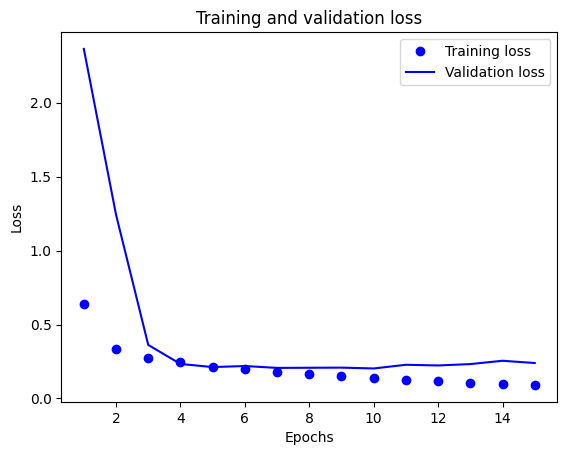

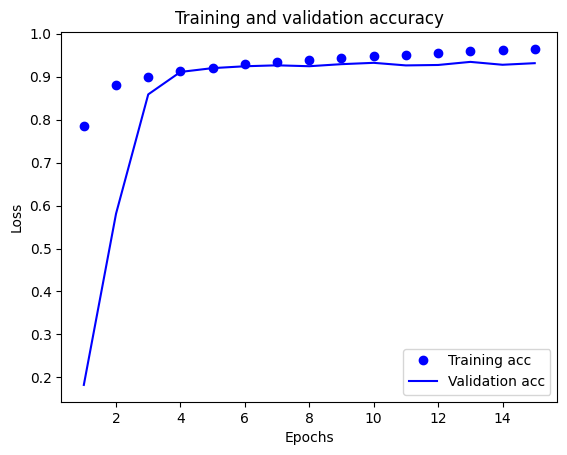

In [52]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [53]:
class_labels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
y_pred = tf.argmax(best_model.predict(test_images), axis=1)
print(classification_report(test_labels, y_pred, target_names=class_labels))

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.87      0.88      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.91      0.89      0.90      1000
       Dress       0.90      0.95      0.92      1000
        Coat       0.88      0.91      0.89      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.81      0.77      0.79      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



## Динаміка позитивна, але є загроза еренавчання, додамо дропаути для обох блоків та ще збільшимо розмір батча до 512. Цього разу не будемо робити ранню зупинку а спробуємо знайти та зберегти модель з найвищою точністю

In [54]:
model_5 = Sequential([
    Conv2D(32, (3, 3), padding='same', activation="relu", input_shape=(28, 28, 1)),
    BatchNormalization(),
    Conv2D(32, (3,3), padding='same', activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), padding='same', activation="relu"),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(10, activation="softmax")
])
model_5.compile(
    optimizer=tf.keras.optimizers.Lion(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
checkpoint = ModelCheckpoint('model_5.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
history = model_5.fit(x_train, y_train, epochs=40, batch_size=512, validation_data=(x_val, y_val), callbacks=[checkpoint])

best_model = tf.keras.models.load_model('model_5.h5')
test_loss, test_acc = best_model.evaluate(test_images, test_labels)

Epoch 1/40
98/98 [==============================] - 5s 30ms/step - loss: 0.9974 - accuracy: 0.6813 - val_loss: 2.2474 - val_accuracy: 0.3572
Epoch 2/40
 5/98 [>.............................] - ETA: 2s - loss: 0.5854 - accuracy: 0.7914

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 [==============================] - 3s 28ms/step - loss: 0.4897 - accuracy: 0.8212 - val_loss: 2.1807 - val_accuracy: 0.1996
Epoch 3/40
98/98 [==============================] - 3s 28ms/step - loss: 0.3879 - accuracy: 0.8605 - val_loss: 2.5043 - val_accuracy: 0.3032
Epoch 4/40
98/98 [==============================] - 3s 28ms/step - loss: 0.3255 - accuracy: 0.8834 - val_loss: 2.3659 - val_accuracy: 0.3952
Epoch 5/40
98/98 [==============================] - 3s 28ms/step - loss: 0.2909 - accuracy: 0.8946 - val_loss: 1.6254 - val_accuracy: 0.6195
Epoch 6/40
98/98 [==============================] - 3s 28ms/step - loss: 0.2634 - accuracy: 0.9033 - val_loss: 0.6486 - val_accuracy: 0.7874
Epoch 7/40
98/98 [==============================] - 3s 28ms/step - loss: 0.2460 - accuracy: 0.9104 - val_loss: 0.5031 - val_accuracy: 0.8382
Epoch 8/40
98/98 [==============================] - 3s 28ms/step - loss: 0.2322 - accuracy: 0.9150 - val_loss: 0.2615 - val_accuracy: 0.9020
Epoch 9/40
98/98 [======

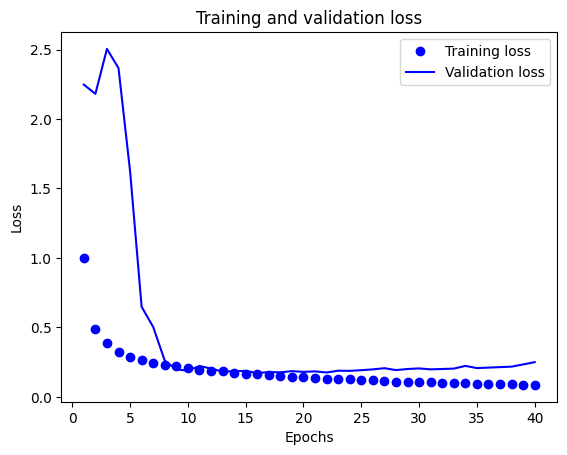

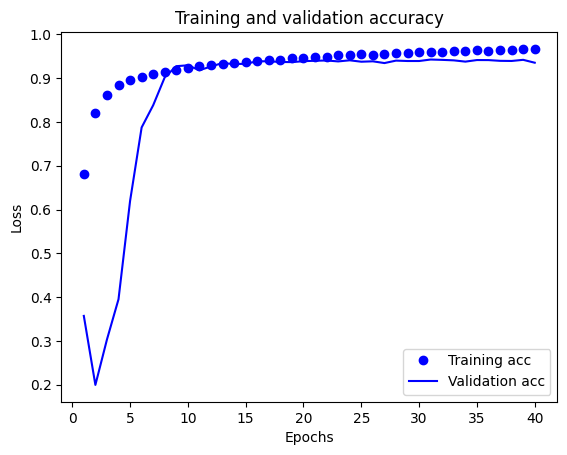

In [55]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [56]:
class_labels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
y_pred = tf.argmax(best_model.predict(test_images), axis=1)
print(classification_report(test_labels, y_pred, target_names=class_labels))

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.90      0.89      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.92      0.91      0.91      1000
       Dress       0.92      0.95      0.93      1000
        Coat       0.90      0.91      0.90      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.82      0.79      0.80      1000
     Sneaker       0.97      0.98      0.98      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



# Вдалося досягти точності приблизно в 94% графіки також показують плато. Зупинимось на цих показниках, бо ресурси та час обмежені.

# Дослідження з VGG16
## Почнемо з VGG16 - згорткова основа, повнозв'язний шар на 512 нейронів батч на 8

### Почнемо з мінімально дозволеного розміру картинки 32х32

In [83]:
vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(vgg_image_size, vgg_image_size, 3))
vgg_base.trainable = False

model_vgg = Sequential([
   vgg_base,
   Flatten(),
   Dense(512, activation="relu"),
   Dense(10, activation="softmax"),
])

model_vgg.compile(
    optimizer=tf.keras.optimizers.Lion(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = K.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_vgg.fit(vgg_x_train, y_train, epochs=15, batch_size=8, validation_data=(vgg_x_val, y_val), callbacks=[early_stop])

test_loss, test_acc = model_vgg.evaluate(vgg_test_images, test_labels)

Epoch 1/15
6250/6250 [==============================] - 24s 4ms/step - loss: 0.6021 - accuracy: 0.7828 - val_loss: 0.5170 - val_accuracy: 0.8066
Epoch 2/15
6250/6250 [==============================] - 23s 4ms/step - loss: 0.4908 - accuracy: 0.8205 - val_loss: 0.5025 - val_accuracy: 0.8154
Epoch 3/15
6250/6250 [==============================] - 23s 4ms/step - loss: 0.4626 - accuracy: 0.8306 - val_loss: 0.4825 - val_accuracy: 0.8219
Epoch 4/15
6250/6250 [==============================] - 23s 4ms/step - loss: 0.4432 - accuracy: 0.8366 - val_loss: 0.4524 - val_accuracy: 0.8333
Epoch 5/15
6250/6250 [==============================] - 23s 4ms/step - loss: 0.4280 - accuracy: 0.8425 - val_loss: 0.4757 - val_accuracy: 0.8313
Epoch 6/15
6250/6250 [==============================] - 23s 4ms/step - loss: 0.4192 - accuracy: 0.8453 - val_loss: 0.4674 - val_accuracy: 0.8331
Epoch 7/15
313/313 [==============================] - 2s 5ms/step - loss: 0.4772 - accuracy: 0.8309


In [85]:
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

### Тепер спробуємо 100х100

In [15]:
vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(vgg_image_size, vgg_image_size, 3))
vgg_base.trainable = False

model_vgg = Sequential([
   vgg_base,
   Flatten(),
   Dense(512, activation="relu"),
   Dense(10, activation="softmax"),
])

model_vgg.compile(
    optimizer=tf.keras.optimizers.Lion(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = K.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_vgg.fit(vgg_x_train, y_train, epochs=15, batch_size=8, validation_data=(vgg_x_val, y_val), callbacks=[early_stop])

test_loss, test_acc = model_vgg.evaluate(vgg_test_images, test_labels)

Epoch 1/15
6250/6250 [==============================] - 60s 9ms/step - loss: 0.5561 - accuracy: 0.8005 - val_loss: 0.4637 - val_accuracy: 0.8306
Epoch 2/15
6250/6250 [==============================] - 57s 9ms/step - loss: 0.4440 - accuracy: 0.8380 - val_loss: 0.4563 - val_accuracy: 0.8342
Epoch 3/15
6250/6250 [==============================] - 57s 9ms/step - loss: 0.4157 - accuracy: 0.8469 - val_loss: 0.4281 - val_accuracy: 0.8424
Epoch 4/15
6250/6250 [==============================] - 57s 9ms/step - loss: 0.3950 - accuracy: 0.8549 - val_loss: 0.4336 - val_accuracy: 0.8458
Epoch 5/15
6250/6250 [==============================] - 58s 9ms/step - loss: 0.3799 - accuracy: 0.8604 - val_loss: 0.4101 - val_accuracy: 0.8549
Epoch 6/15
6250/6250 [==============================] - 59s 9ms/step - loss: 0.3670 - accuracy: 0.8648 - val_loss: 0.4246 - val_accuracy: 0.8523
Epoch 7/15
6250/6250 [==============================] - 57s 9ms/step - loss: 0.3581 - accuracy: 0.8670 - val_loss: 0.4395 - val_ac

In [7]:
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

## Як бачимо єфективніше працювати з більшими забраженнями. Базова точність 85%, збільшимо батч до 16

In [14]:
vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(vgg_image_size, vgg_image_size, 3))
vgg_base.trainable = False

model_vgg = Sequential([
   vgg_base,
   Flatten(),
   Dense(512, activation="relu"),
   Dense(10, activation="softmax"),
])

model_vgg.compile(
    optimizer=tf.keras.optimizers.Lion(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = K.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_vgg.fit(vgg_x_train, y_train, epochs=15, batch_size=16, validation_data=(vgg_x_val, y_val), callbacks=[early_stop])

test_loss, test_acc = model_vgg.evaluate(vgg_test_images, test_labels)

Epoch 1/15
3125/3125 [==============================] - 38s 12ms/step - loss: 0.4710 - accuracy: 0.8317 - val_loss: 0.3976 - val_accuracy: 0.8547
Epoch 2/15
3125/3125 [==============================] - 37s 12ms/step - loss: 0.3629 - accuracy: 0.8671 - val_loss: 0.3740 - val_accuracy: 0.8629
Epoch 3/15
3125/3125 [==============================] - 41s 13ms/step - loss: 0.3331 - accuracy: 0.8790 - val_loss: 0.3605 - val_accuracy: 0.8697
Epoch 4/15
3125/3125 [==============================] - 42s 13ms/step - loss: 0.3142 - accuracy: 0.8850 - val_loss: 0.3575 - val_accuracy: 0.8689
Epoch 5/15
3125/3125 [==============================] - 37s 12ms/step - loss: 0.2975 - accuracy: 0.8894 - val_loss: 0.3582 - val_accuracy: 0.8721
Epoch 6/15
3125/3125 [==============================] - 36s 12ms/step - loss: 0.2837 - accuracy: 0.8957 - val_loss: 0.3576 - val_accuracy: 0.8757
Epoch 7/15
313/313 [==============================] - 5s 15ms/step - loss: 0.3689 - accuracy: 0.8705


## Точність зросла до 87% збільшимо батч до 64 додамо шар дропаут

In [20]:
vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(vgg_image_size, vgg_image_size, 3))
vgg_base.trainable = False

model_vgg = Sequential([
   vgg_base,
   Flatten(),
   Dense(512, activation="relu"),
   Dropout(0.5),
   Dense(10, activation="softmax"),
])

model_vgg.compile(
    optimizer=tf.keras.optimizers.Lion(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = K.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_vgg.fit(vgg_x_train, y_train, epochs=15, batch_size=64, validation_data=(vgg_x_val, y_val), callbacks=[early_stop])

test_loss, test_acc = model_vgg.evaluate(vgg_test_images, test_labels)

Epoch 1/15
782/782 [==============================] - 61s 73ms/step - loss: 0.5548 - accuracy: 0.8015 - val_loss: 0.3692 - val_accuracy: 0.8646
Epoch 2/15
782/782 [==============================] - 57s 73ms/step - loss: 0.3954 - accuracy: 0.8593 - val_loss: 0.3385 - val_accuracy: 0.8724
Epoch 3/15
782/782 [==============================] - 57s 73ms/step - loss: 0.3736 - accuracy: 0.8658 - val_loss: 0.3312 - val_accuracy: 0.8750
Epoch 4/15
782/782 [==============================] - 57s 73ms/step - loss: 0.3587 - accuracy: 0.8693 - val_loss: 0.3173 - val_accuracy: 0.8798
Epoch 5/15
782/782 [==============================] - 57s 73ms/step - loss: 0.3444 - accuracy: 0.8740 - val_loss: 0.3171 - val_accuracy: 0.8815
Epoch 6/15
782/782 [==============================] - 57s 73ms/step - loss: 0.3378 - accuracy: 0.8781 - val_loss: 0.3128 - val_accuracy: 0.8831
Epoch 7/15
782/782 [==============================] - 57s 73ms/step - loss: 0.3370 - accuracy: 0.8765 - val_loss: 0.3150 - val_accuracy:

## Точність зросла до 88%. Збільшимо батч до 256

In [6]:
vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(vgg_image_size, vgg_image_size, 3))
vgg_base.trainable = False

model_vgg = Sequential([
   vgg_base,
   Flatten(),
   LayerNormalization(),
   Dense(512, activation="relu"),
   Dropout(0.5),
   Dense(10, activation="softmax"),
])

model_vgg.compile(
    optimizer=tf.keras.optimizers.Lion(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = K.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_vgg.fit(vgg_x_train, y_train, epochs=25, batch_size=256, validation_data=(vgg_x_val, y_val), callbacks=[early_stop])

test_loss, test_acc = model_vgg.evaluate(vgg_test_images, test_labels)

Epoch 1/25
196/196 [==============================] - 50s 201ms/step - loss: 0.7152 - accuracy: 0.7483 - val_loss: 0.4219 - val_accuracy: 0.8446
Epoch 2/25
196/196 [==============================] - 36s 182ms/step - loss: 0.4237 - accuracy: 0.8476 - val_loss: 0.3538 - val_accuracy: 0.8667
Epoch 3/25
196/196 [==============================] - 36s 182ms/step - loss: 0.3781 - accuracy: 0.8612 - val_loss: 0.3317 - val_accuracy: 0.8734
Epoch 4/25
196/196 [==============================] - 36s 182ms/step - loss: 0.3456 - accuracy: 0.8743 - val_loss: 0.3189 - val_accuracy: 0.8768
Epoch 5/25
196/196 [==============================] - 36s 182ms/step - loss: 0.3299 - accuracy: 0.8800 - val_loss: 0.3102 - val_accuracy: 0.8816
Epoch 6/25
196/196 [==============================] - 36s 182ms/step - loss: 0.3162 - accuracy: 0.8856 - val_loss: 0.3037 - val_accuracy: 0.8854
Epoch 7/25
196/196 [==============================] - 36s 182ms/step - loss: 0.3066 - accuracy: 0.8887 - val_loss: 0.2997 - val_ac

## Маємо точність 89%. Подивимось структуру мережі VGG16 яку використовуємо

In [8]:
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

## Наші картинки все одно доволі малі, спробуємо взяти лише перші 4 блоки, і подивимось як це вплине на точність

In [20]:
vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(vgg_image_size, vgg_image_size, 3))
vgg_base.trainable = False

model_vgg = Sequential([
   *vgg_base.layers[:15],
   Flatten(),
   LayerNormalization(),
   Dense(512, activation="relu", activity_regularizer="L1L2"),
   Dense(10, activation="softmax"),
])

model_vgg.compile(
    optimizer=tf.keras.optimizers.Lion(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = K.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_vgg.fit(vgg_x_train, y_train, epochs=25, batch_size=256, validation_data=(vgg_x_val, y_val), callbacks=[early_stop])

test_loss, test_acc = model_vgg.evaluate(vgg_test_images, test_labels)

Epoch 1/25
196/196 [==============================] - 36s 181ms/step - loss: 0.4611 - accuracy: 0.8512 - val_loss: 0.3007 - val_accuracy: 0.8901
Epoch 2/25
196/196 [==============================] - 35s 179ms/step - loss: 0.2262 - accuracy: 0.9167 - val_loss: 0.2599 - val_accuracy: 0.9076
Epoch 3/25
196/196 [==============================] - 35s 178ms/step - loss: 0.1723 - accuracy: 0.9369 - val_loss: 0.2480 - val_accuracy: 0.9128
Epoch 4/25
196/196 [==============================] - 35s 178ms/step - loss: 0.1393 - accuracy: 0.9489 - val_loss: 0.2465 - val_accuracy: 0.9162
Epoch 5/25
196/196 [==============================] - 35s 178ms/step - loss: 0.1171 - accuracy: 0.9578 - val_loss: 0.2629 - val_accuracy: 0.9129
Epoch 6/25
196/196 [==============================] - 35s 178ms/step - loss: 0.0973 - accuracy: 0.9654 - val_loss: 0.2740 - val_accuracy: 0.9133
Epoch 7/25
313/313 [==============================] - 6s 20ms/step - loss: 0.2690 - accuracy: 0.9080


# Динаміка позитивна, тепер спробуємо лише перші три блоки

In [57]:
vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(vgg_image_size, vgg_image_size, 3))
vgg_base.trainable = False

model_vgg = Sequential([
   *vgg_base.layers[:11],
   Flatten(),
   LayerNormalization(),
   Dense(512, activation="relu", activity_regularizer="L1L2"),
   Dense(10, activation="softmax"),
])

model_vgg.compile(
    optimizer=tf.keras.optimizers.Lion(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = K.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_vgg.fit(vgg_x_train, y_train, epochs=25, batch_size=256, validation_data=(vgg_x_val, y_val), callbacks=[early_stop])

test_loss, test_acc = model_vgg.evaluate(vgg_test_images, test_labels)

Epoch 1/25
196/196 [==============================] - 32s 158ms/step - loss: 0.6088 - accuracy: 0.8421 - val_loss: 0.3441 - val_accuracy: 0.8874
Epoch 2/25
196/196 [==============================] - 30s 154ms/step - loss: 0.2406 - accuracy: 0.9144 - val_loss: 0.2663 - val_accuracy: 0.9051
Epoch 3/25
196/196 [==============================] - 30s 154ms/step - loss: 0.1861 - accuracy: 0.9334 - val_loss: 0.2551 - val_accuracy: 0.9103
Epoch 4/25
196/196 [==============================] - 30s 155ms/step - loss: 0.1542 - accuracy: 0.9449 - val_loss: 0.2353 - val_accuracy: 0.9184
Epoch 5/25
196/196 [==============================] - 30s 155ms/step - loss: 0.1317 - accuracy: 0.9523 - val_loss: 0.2314 - val_accuracy: 0.9195
Epoch 6/25
196/196 [==============================] - 30s 154ms/step - loss: 0.1122 - accuracy: 0.9594 - val_loss: 0.2371 - val_accuracy: 0.9205
Epoch 7/25
196/196 [==============================] - 30s 154ms/step - loss: 0.0981 - accuracy: 0.9649 - val_loss: 0.2502 - val_ac

In [67]:
vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(vgg_image_size, vgg_image_size, 3))
vgg_base.trainable = False

model_vgg = Sequential([
   *vgg_base.layers[:11],
   Flatten(),
   Dense(256, activation="relu"),
   Dropout(0.5),
   BatchNormalization(),
   Dense(10, activation="softmax"),
])

model_vgg.compile(
    optimizer=tf.keras.optimizers.Lion(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = K.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_vgg.fit(vgg_x_train, y_train, epochs=15, batch_size=512, validation_data=(vgg_x_val, y_val), callbacks=[early_stop])

test_loss, test_acc = model_vgg.evaluate(vgg_test_images, test_labels)

Epoch 1/15
98/98 [==============================] - 32s 312ms/step - loss: 0.5029 - accuracy: 0.8280 - val_loss: 0.3982 - val_accuracy: 0.8755
Epoch 2/15
98/98 [==============================] - 29s 298ms/step - loss: 0.3549 - accuracy: 0.8754 - val_loss: 0.3120 - val_accuracy: 0.8927
Epoch 3/15
98/98 [==============================] - 29s 297ms/step - loss: 0.3112 - accuracy: 0.8887 - val_loss: 0.2743 - val_accuracy: 0.9025
Epoch 4/15
98/98 [==============================] - 29s 299ms/step - loss: 0.2789 - accuracy: 0.8998 - val_loss: 0.2503 - val_accuracy: 0.9089
Epoch 5/15
98/98 [==============================] - 29s 300ms/step - loss: 0.2546 - accuracy: 0.9089 - val_loss: 0.2418 - val_accuracy: 0.9131
Epoch 6/15
98/98 [==============================] - 29s 298ms/step - loss: 0.2322 - accuracy: 0.9169 - val_loss: 0.2255 - val_accuracy: 0.9171
Epoch 7/15
98/98 [==============================] - 29s 299ms/step - loss: 0.2112 - accuracy: 0.9248 - val_loss: 0.2196 - val_accuracy: 0.9178

## Точність підвищилась до 92%. Донавчимо третій блок, він останній з тих що ми використовуємо

In [10]:
vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(vgg_image_size, vgg_image_size, 3))
vgg_base.trainable = True

set_trainable = False
for layer in vgg_base.layers:
    if layer.name == "block3_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model_vgg = Sequential([
   *vgg_base.layers[:11],

   Flatten(),
   Dense(256, activation="relu"),
   Dropout(0.5),
   BatchNormalization(),
   Dense(10, activation="softmax"),
])

model_vgg.compile(
    optimizer=tf.keras.optimizers.Lion(learning_rate=0.00001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = K.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_vgg.fit(vgg_x_train, y_train, epochs=25, batch_size=512, validation_data=(vgg_x_val, y_val), callbacks=[early_stop])

test_loss, test_acc = model_vgg.evaluate(vgg_test_images, test_labels)

Epoch 1/25
98/98 [==============================] - 59s 525ms/step - loss: 0.7653 - accuracy: 0.7407 - val_loss: 0.4139 - val_accuracy: 0.8592
Epoch 2/25
98/98 [==============================] - 33s 336ms/step - loss: 0.3964 - accuracy: 0.8635 - val_loss: 0.3109 - val_accuracy: 0.8911
Epoch 3/25
98/98 [==============================] - 33s 339ms/step - loss: 0.3206 - accuracy: 0.8884 - val_loss: 0.2800 - val_accuracy: 0.9065
Epoch 4/25
98/98 [==============================] - 33s 338ms/step - loss: 0.2696 - accuracy: 0.9066 - val_loss: 0.2609 - val_accuracy: 0.9106
Epoch 5/25
98/98 [==============================] - 33s 337ms/step - loss: 0.2357 - accuracy: 0.9189 - val_loss: 0.2285 - val_accuracy: 0.9215
Epoch 6/25
98/98 [==============================] - 33s 337ms/step - loss: 0.2052 - accuracy: 0.9300 - val_loss: 0.2270 - val_accuracy: 0.9248
Epoch 7/25
98/98 [==============================] - 33s 337ms/step - loss: 0.1788 - accuracy: 0.9402 - val_loss: 0.2145 - val_accuracy: 0.9291

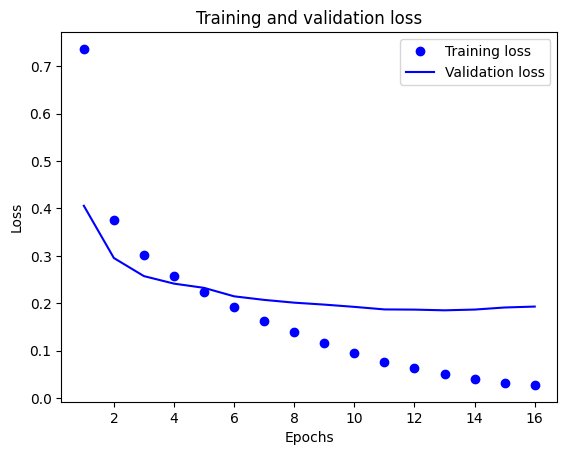

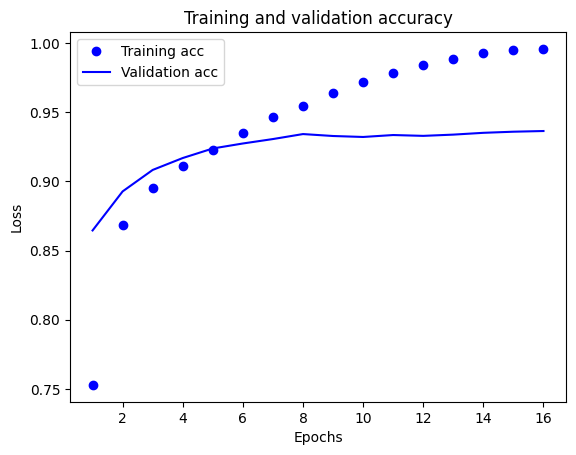

In [12]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [16]:
class_labels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
y_pred = tf.argmax(model_vgg.predict(vgg_test_images), axis=1)
print(classification_report(test_labels, y_pred, target_names=class_labels))

313/313 [==============================] - 5s 15ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.87      0.88      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.88      0.90      0.89      1000
       Dress       0.93      0.94      0.93      1000
        Coat       0.87      0.90      0.88      1000
      Sandal       0.99      0.99      0.99      1000
       Shirt       0.80      0.77      0.78      1000
     Sneaker       0.97      0.98      0.98      1000
         Bag       0.98      0.99      0.99      1000
  Ankle boot       0.98      0.97      0.98      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



### Отримали точність у 93%. Спробуємо навчання з аугментацією даних

In [17]:
vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(vgg_image_size, vgg_image_size, 3))
vgg_base.trainable = True

set_trainable = False
for layer in vgg_base.layers:
    if layer.name == "block3_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model_vgg = Sequential([
   *vgg_base.layers[:11],

   Flatten(),
   Dense(256, activation="relu"),
   Dropout(0.5),
   BatchNormalization(),
   Dense(10, activation="softmax"),
])

model_vgg.compile(
    optimizer=tf.keras.optimizers.Lion(learning_rate=0.00001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [18]:
early_stoping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
datagen = K.preprocessing.image.ImageDataGenerator(
                                                    horizontal_flip=True,
                                                    width_shift_range=0.1,
                                                    height_shift_range=0.1
                                                    )


train_gen = datagen.flow(vgg_x_train,y_train, batch_size=64)

history = model_vgg.fit(train_gen,
                        validation_data=(vgg_x_val,y_val),
                        epochs=50,
                        callbacks=[early_stoping])

Epoch 1/50
782/782 [==============================] - 117s 145ms/step - loss: 0.6831 - accuracy: 0.7634 - val_loss: 0.3638 - val_accuracy: 0.8712
Epoch 2/50
782/782 [==============================] - 114s 146ms/step - loss: 0.3992 - accuracy: 0.8607 - val_loss: 0.2943 - val_accuracy: 0.8928
Epoch 3/50
782/782 [==============================] - 115s 147ms/step - loss: 0.3507 - accuracy: 0.8780 - val_loss: 0.2643 - val_accuracy: 0.9065
Epoch 4/50
782/782 [==============================] - 114s 146ms/step - loss: 0.3109 - accuracy: 0.8903 - val_loss: 0.2462 - val_accuracy: 0.9080
Epoch 5/50
782/782 [==============================] - 114s 145ms/step - loss: 0.2898 - accuracy: 0.8967 - val_loss: 0.2373 - val_accuracy: 0.9124
Epoch 6/50
782/782 [==============================] - 114s 146ms/step - loss: 0.2772 - accuracy: 0.9011 - val_loss: 0.2275 - val_accuracy: 0.9178
Epoch 7/50
782/782 [==============================] - 113s 145ms/step - loss: 0.2591 - accuracy: 0.9083 - val_loss: 0.2268 -

In [19]:
test_loss, test_acc = model_vgg.evaluate(vgg_test_images, test_labels)

313/313 [==============================] - 5s 16ms/step - loss: 0.2220 - accuracy: 0.9241


### Результат навіть трохи гірший

# Висновки
## Частина 1
### В порівнянні з повнозв'язною мережею, згорткова, на даному датасеті, показала кращі результати 94% в порівнянні з 90%. Це пов'язано з її так би мовити налаштованістю на розпізнавання образів, виділення форм кольорів і ті.
### Статистика розпізнавання по класам має набагато кращий вигляд, CNN краще розпіснає схожі категорії товарів, майже не плутаючи їх.
### Паддінг на даному датасеті виявився корисним, бо зображення не мають так би мовити "рамки".
### Дуже корисним виявився Lion-оптимізатор, дає дуже плавне сходження до мінімума
### При використанні шарів дропаут краще збільшувати розмір батча
### Налаштування параметрів мережі дуже важливе, адже без цього важко відчути переваги CNN.

## Частина 2
### Використання глибокої CNN вимагає великих потужностей.
### Результат при використанні VGG16 кращий ніж при використанні DNN але гірший за модель створену в частині 1 та навчену виключно на даних призначених для неї. Вважаю тут зіграли декілька факторів, можливість більш тонкого налаштування, та пристосованість саме до такого формату зображень. Скоріш за все VGG16 навачалася на зображеннях більш високої розподільної здатності, до того ж кольрових і це не дало в повній мірі розкрити всю силу даної моделі. Глибокі шари моделі просто розпорошують зображення на атоми. Це підтверджує той факт, що ми спостерігали зростання точності розпізнавання коли відкинули два нижні блоки.
### Донавчання не дало очікуваного приросту якості
### Аугментація даних як і очікувалося для даного типу зображень не дала результату




